# Hybrid Inference with Normalizing Flows in Factor Graphs

## Load packages

In [1]:
using Random
using LinearAlgebra
using PyPlot
using LaTeXStrings
using HDF5
using Distributions
using Optim
using Revise
using ProgressMeter

using ReactiveMP
using GraphPPL
using Rocket;

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278


## Generate data

In [2]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

In [3]:
data_y, data_x = generate_data(200)
if !isfile("exports/data/generated_data.h5")
    h5write("exports/data/generated_data.h5", "x", data_x)
    h5write("exports/data/generated_data.h5", "y", data_y)
end;

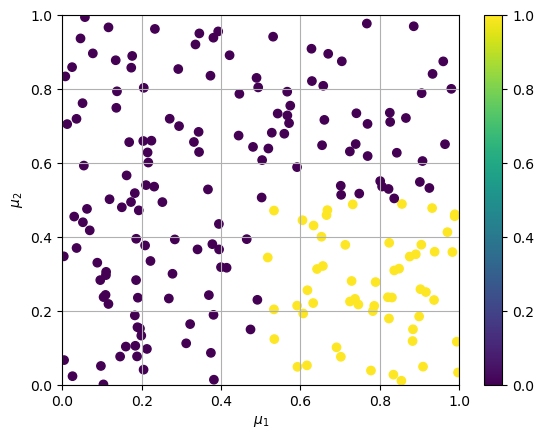

In [4]:
plt.scatter(data_x[:,1], data_x[:,2], c=data_y)
plt.grid()
plt.xlabel(L"$\mu_1$")
plt.ylabel(L"$\mu_2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.colorbar();

## Model specification

In [5]:
@model function flow_classifier(nr_samples::Int64, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                        ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                        NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                        ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
    meta  = FlowMeta(model) # default: FlowMeta(model, Linearization())

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

## Probabilistic Inference

In [6]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [7]:
function f(params)
    fe = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], params)
    return fe
end;

## Experimental validation

In [24]:
res = optimize(f, randn(12), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.286079e+03     2.050069e+03
 * time: 0.0
     1     2.259022e+02     1.727415e+02
 * time: 0.47699999809265137
     2     2.159954e+02     5.892722e+01
 * time: 0.7460000514984131
     3     1.675825e+02     1.423550e+02
 * time: 1.3410000801086426
     4     1.590399e+02     1.894957e+02
 * time: 1.6400001049041748
     5     1.093557e+02     1.996780e+02
 * time: 1.931999921798706
     6     6.506000e+01     7.301212e+01
 * time: 2.184999942779541
     7     5.841827e+01     2.459508e+01
 * time: 2.3420000076293945
     8     5.616401e+01     3.289408e+01
 * time: 2.6410000324249268
     9     5.078179e+01     6.385074e+01
 * time: 2.865000009536743
    10     4.541629e+01     2.305224e+01
 * time: 3.0910000801086426
    11     4.164706e+01     3.403420e+01
 * time: 3.2680001258850098
    12     3.920795e+01     2.560482e+01
 * time: 3.4119999408721924
    13     3.745653e+01     4.287277e+01
 * time: 3.5269999504089355
    14    

 * Status: success

 * Candidate solution
    Final objective value:     1.147328e-09

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.18e-01 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.08e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.09e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.51e-03 ≰ 0.0e+00
    |g(x)|                 = 2.93e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   25  (vs limit Inf)
    Iterations:    119
    f(x) calls:    402
    ∇f(x) calls:   402


## Visualisation: Warping

In [25]:
function uniformpdf(y; xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    indomain = 1.0*(xmin <= y[1] <= xmax)*(ymin <= y[2] <= ymax)
    return indomain/(xmax-xmin)/(ymax-ymin)
end

uniformpdf (generic function with 1 method)

In [26]:
params = Optim.minimizer(res)
inferred_model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                             ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                             NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                             ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
if !isfile("exports/data/transformed_data.h5")
    h5write("exports/data/transformed_data.h5", "x_init", data_x)
    h5write("exports/data/transformed_data.h5", "x_transformed", trans_data_x_1')
    h5write("exports/data/transformed_data.h5", "x_hist", trans_data_x_2)
    h5write("exports/data/transformed_data.h5", "y_init", data_y)    
end;

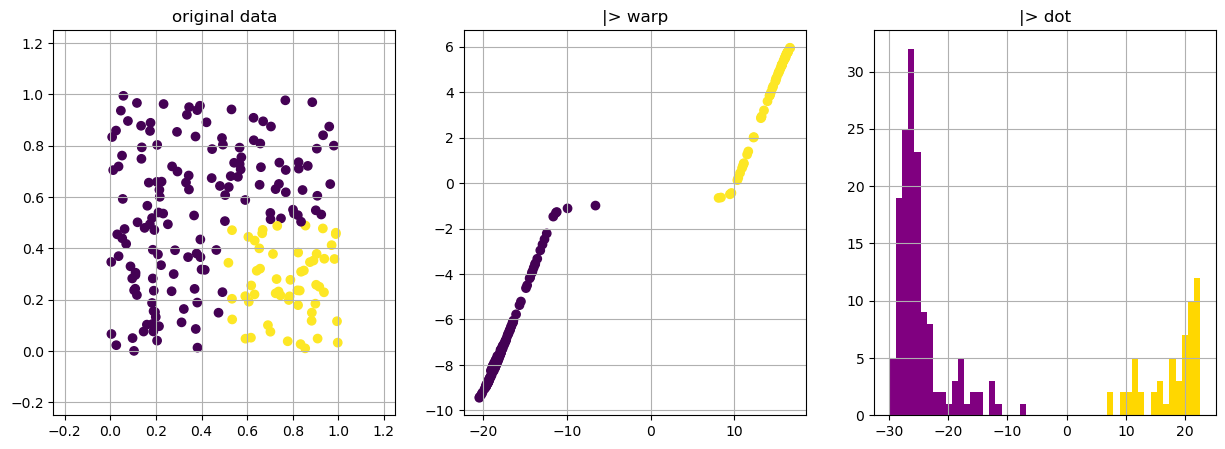

In [27]:
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

## Visualisation: Classification

In [28]:
@model function flow_classifier_visualisation(nr_samples::Int64, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = randomvar(nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify model
    model = FlowModel( (NiceLayer(         PlanarMap(params[1],  params[2],  params[3])),
                        ReverseNiceLayer(  PlanarMap(params[4],  params[5],  params[6])),
                        NiceLayer(         PlanarMap(params[7],  params[8],  params[9])),
                        ReverseNiceLayer(  PlanarMap(params[10], params[11], params[12]))))
    meta  = FlowMeta(model) # default: FlowMeta(model, Linearization())

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }
        y[k] ~ Bernoulli(0.5)

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

In [29]:
function inference_flow_classifier_visualisation(data_x::Array{Array{Float64,1},1}, params; nr_iterations=10)
    
    # fetch number of samples
    nr_samples = length(data_x)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier_visualisation(nr_samples, params)

    # initialize output marginal buffer
    my = buffer(Marginal, nr_samples)
    
    # subscribe
    y_sub  = subscribe!(getmarginals(y), my)

    # update y and x according to observations (i.e. perform inference)
    for it = 1:nr_iterations
        ReactiveMP.update!(x, data_x)
    end

    # unsubscribe
    unsubscribe!(y_sub)
    
    # return the marginal values
    return my

end;

In [37]:
predicted_classes = mean.(inference_flow_classifier_visualisation([data_x[k,:] for k = 1:length(data_y)], params))
classification_map = inference_flow_classifier_visualisation(collect.([collect(Iterators.product(0:0.01:1, 0:0.01:1))...]), params)
classification_map = reshape(mean.(classification_map), (Int(sqrt(length(classification_map))), Int(sqrt(length(classification_map)))))
if !isfile("exports/data/classified_data.h5")
    h5write("exports/data/classified_data.h5", "x_init", data_x)
    h5write("exports/data/classified_data.h5", "y_init", data_y)
    h5write("exports/data/classified_data.h5", "y_pred", predicted_classes)
    h5write("exports/data/classified_data.h5", "x_map", hcat(collect.([collect(Iterators.product(0:0.01:1, 0:0.01:1))...])...))    
    h5write("exports/data/classified_data.h5", "y_map", vcat(classification_map...))    
end;

In [ ]:
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = predicted_classes)
ax[3].contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");

In [138]:
params_comparison = [   -16.971881527516572
                        1.6906882449748233
                        9.58620537310562
                        14.41799007763637
                        -0.6356073743299993
                        -8.584499681932611
                        11.320057543140475
                        3.0874286057733142
                        6.461029274995887
                        45.81004120933731
                        -7.228339234945879
                        -41.09968671707267]
f(params_comparison)

9.66062498080828